###  Demonstrate the effectiveness of RAG to cite sources and to prevent hallucination.

In [3]:
# !pip install transformers datasets faiss-cpu sentence-transformers

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer
import torch
import faiss
import numpy as np

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large-cnn')

product_info = [
    "The ChatGPT O1 model supports a maximum context length of 8192 tokens.",
    "The ChatGPT O1 model is capable of understanding and generating text in over 50 languages.",
    "The ChatGPT O1 model features improved reasoning and problem-solving capabilities.",
    "The ChatGPT O1 model includes real-time data retrieval for up-to-date information.",
    "The ChatGPT O1 model is optimized for conversational AI applications with enhanced context awareness.",
]


product_embeddings = embedding_model.encode(product_info)


# i have added this from my current research work that i am doing at LeRobot
# Build the FAISS index We build a FAISS index to enable efficient similarity search

dimension = product_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(product_embeddings, dtype=np.float32))



# Function to get relevant information
def get_relevant_info(query, embeddings, texts, top_k=2):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(np.array(query_embedding, dtype=np.float32), top_k)
    relevant_texts = [texts[idx] for idx in indices[0]]
    return relevant_texts

# Function to generate response using the language model
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors='pt', max_length=512, truncation=True)
    outputs = generation_model.generate(
        inputs['input_ids'], 
        max_length=150, 
        num_beams=5, 
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Function to generate RAG response
def rag_response(query):
    relevant_info = get_relevant_info(query, product_embeddings, product_info)
    context = "\n".join(relevant_info)
    prompt = f"Based on the following information:\n{context}\n\nPlease answer the user's question: {query}"
    return generate_response(prompt)

# Function to generate non-RAG response
def non_rag_response(query):
    # we dont need any thing in this function
    
    return generate_response(query)

# Compare RAG and Non-RAG responses
def compare_responses(query):
    rag_resp = rag_response(query)
    non_rag_resp = non_rag_response(query)
    
    print(f"Query: {query}\n")
    print("RAG Response:")
    print(rag_resp)
    print("\nNon-RAG Response:")
    print(non_rag_resp)
    print("="*50 + "\n")

queries = [
    "What is the maximum context length of the ChatGPT O1 model?",
    "Does the ChatGPT O1 model support multiple languages?",
    "What are the new features of the ChatGPT O1 model?",
    "Can the ChatGPT O1 model access real-time information?",
]


for q in queries:
    compare_responses(q)


C:\Users\patel\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Query: What is the maximum context length of the ChatGPT O1 model?

RAG Response:
The ChatGPT O1 model supports a maximum context length of 8192 tokens. The model is capable of understanding and generating text in over 50 languages. Based on the following information, the user's question can be answered: What is the maximum Context Length of this model?

Non-RAG Response:
What is the maximum context length of the ChatGPT O1 model? How long can a message be in the chat window before it is deleted? What are the limits on the number of words that can be shown in a single message? Are there any limits to how many words a user can show at a time? Is there a limit to the amount of text a person can display?

Query: Does the ChatGPT O1 model support multiple languages?

RAG Response:
The ChatGPT O1 model is capable of understanding and generating text in over 50 languages. The model includes real-time data retrieval for up-to-date information. Based on the following information, the model can

#### as you can see the non rag prompts halucinates by far - not even giving the domain results

---

# Introduction to Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is a framework that combines the strengths of retrieval-based models and generative models to produce more accurate and informative responses. Developed to enhance the capabilities of language models, RAG addresses two significant challenges in natural language processing:

1. **Hallucination**: The tendency of language models to generate plausible-sounding but incorrect or nonsensical information.
2. **Lack of Source Citation**: Difficulty in providing verifiable sources for the generated content, which is crucial for applications requiring transparency and trustworthiness.

By integrating external knowledge retrieval into the generation process, RAG ensures that the responses are both accurate and accompanied by relevant sources.

---

## How RAG Works

At its core, RAG operates in two main steps:

### Retrieval Step

**Objective**: *Fetch relevant documents or pieces of information from an external knowledge base.*

**Process**:

1. The input query is used to search a large corpus (e.g., Wikipedia, proprietary databases).
2. A retrieval model (like **DPR**—Dense Passage Retrieval) encodes the query and documents into embeddings.
3. The top-*k* relevant documents are retrieved based on similarity scores.

### Generation Step

**Objective**: *Generate a response using both the input query and the retrieved documents.*

**Process**:

1. A generative model (like **BART** or **T5**) takes the query and the retrieved documents as input.
2. It generates a coherent and informative response, grounding the information in the retrieved content.
3. The model can cite the sources by referencing the retrieved documents.

---

## Illustration of RAG Workflow

**User Query**: *"What are the health benefits of green tea?"*

### Retrieval Module

- Encodes the query.
- Searches the knowledge base.
- Retrieves top 3 documents related to green tea's health benefits.

### Generation Module

- Receives the query and the retrieved documents.
- Generates a response like:

  > *"Green tea is rich in antioxidants, which can improve brain function, aid in fat loss, and lower the risk of cancer [Source: Document 1]."*

---

## Effectiveness in Citing Sources

1. **Grounded Responses**: By using actual documents retrieved from trusted sources, RAG ensures that the generated content is based on verifiable information.

2. **Source Attribution**:

   - The model is designed to reference the specific documents used to generate the response.
   - This attribution allows users to verify the information and builds trust.

   **Example**:

   > *"According to a study published in the Journal of Nutrition [Source: Document A], consuming green tea can boost metabolism and improve cardiovascular health."*

   In this example, the model cites "Document A," which the user can refer to for more details.

---

## Preventing Hallucinations

1. **Dependence on Retrieved Content**:

   - The generative model conditions its output on the retrieved documents.
   - This grounding reduces the likelihood of fabricating information not present in the sources.

2. **Reinforcement Learning and Fine-Tuning**:

   - RAG models can be fine-tuned to prioritize information from retrieved documents.
   - Techniques like contrastive learning help the model distinguish between accurate and hallucinated content.

3. **Use of Attention Mechanisms**:

   - The model focuses on relevant parts of the retrieved documents.
   - Attention scores can be visualized to show how the model weighs different pieces of information.

   **Illustration of Attention Mechanism**:

   Imagine a heatmap over the text of the retrieved documents, highlighting the sentences the model focused on most when generating the response.

---

## Advantages of RAG in Practical Applications

- **Improved Accuracy**: By grounding responses in real documents, the accuracy of information increases.
- **Transparency**: Citing sources enhances transparency, crucial for domains like healthcare, law, and education.
- **User Trust**: Users are more likely to trust responses that come with verifiable sources.
- **Regulatory Compliance**: For applications requiring adherence to regulations (e.g., GDPR, academic standards), RAG's ability to cite sources is beneficial.

---

## Challenges and Considerations

While RAG offers significant advantages, certain challenges need to be addressed:

- **Quality of Retrieved Documents**:

  - If the retrieval step fetches irrelevant or low-quality documents, the generated response may still suffer.
  - Ensuring a high-quality, up-to-date knowledge base is essential.

- **Computational Complexity**:

  - RAG models can be resource-intensive due to the retrieval and generation steps.
  - Optimization techniques are necessary for deployment in real-time applications.

- **Handling Ambiguous Queries**:

  - The model may struggle to retrieve relevant documents if the query is vague.
  - Incorporating user feedback mechanisms can help refine retrieval.

---

## Conclusion

Retrieval-Augmented Generation (RAG) effectively enhances language models by grounding their outputs in real, retrievable documents. This grounding helps in:

- **Citing Sources**: By providing references to the documents used, RAG models increase the transparency and trustworthiness of their responses.
- **Preventing Hallucinations**: Reliance on retrieved content reduces the tendency of the model to produce unverified or false information.

---
## References

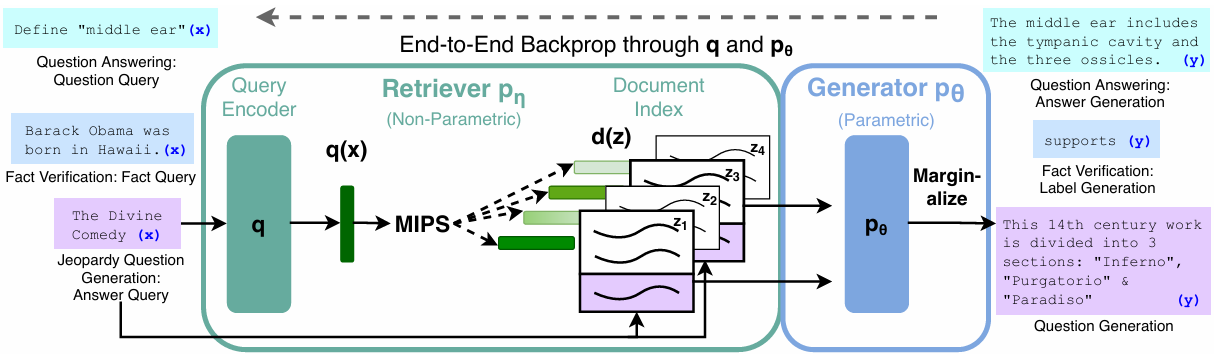 <br>

- Lewis, P., et al. (2020). [link]**Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks.** *Advances in Neural Information Processing Systems*.
- Karpukhin, V., et al. (2020). [link]**Dense Passage Retrieval for Open-Domain Question Answering.** *Empirical Methods in Natural Language Processing*.

---

### Study the back-propagation algorithm. Implement a classifier for the loan data with Decision as the output attribute. Prepare the data as needed. Submit the notebook file.

Training set shape: (379, 35)
Test set shape: (95, 35)
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.6454 - accuracy: 0.6148 - val_loss: 0.5978 - val_accuracy: 0.7263
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7150 - val_loss: 0.5446 - val_accuracy: 0.6842
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.7599 - val_loss: 0.4967 - val_accuracy: 0.7474
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.4565 - accuracy: 0.8127 - val_loss: 0.4848 - val_accuracy: 0.7368
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.8153 - val_loss: 0.4713 - val_accuracy: 0.7684
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4089 - accuracy: 0.8206 - val_loss: 0.4676 - val_accuracy: 0.7684
Epoch 7/50
38/38 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.8443 - val_l

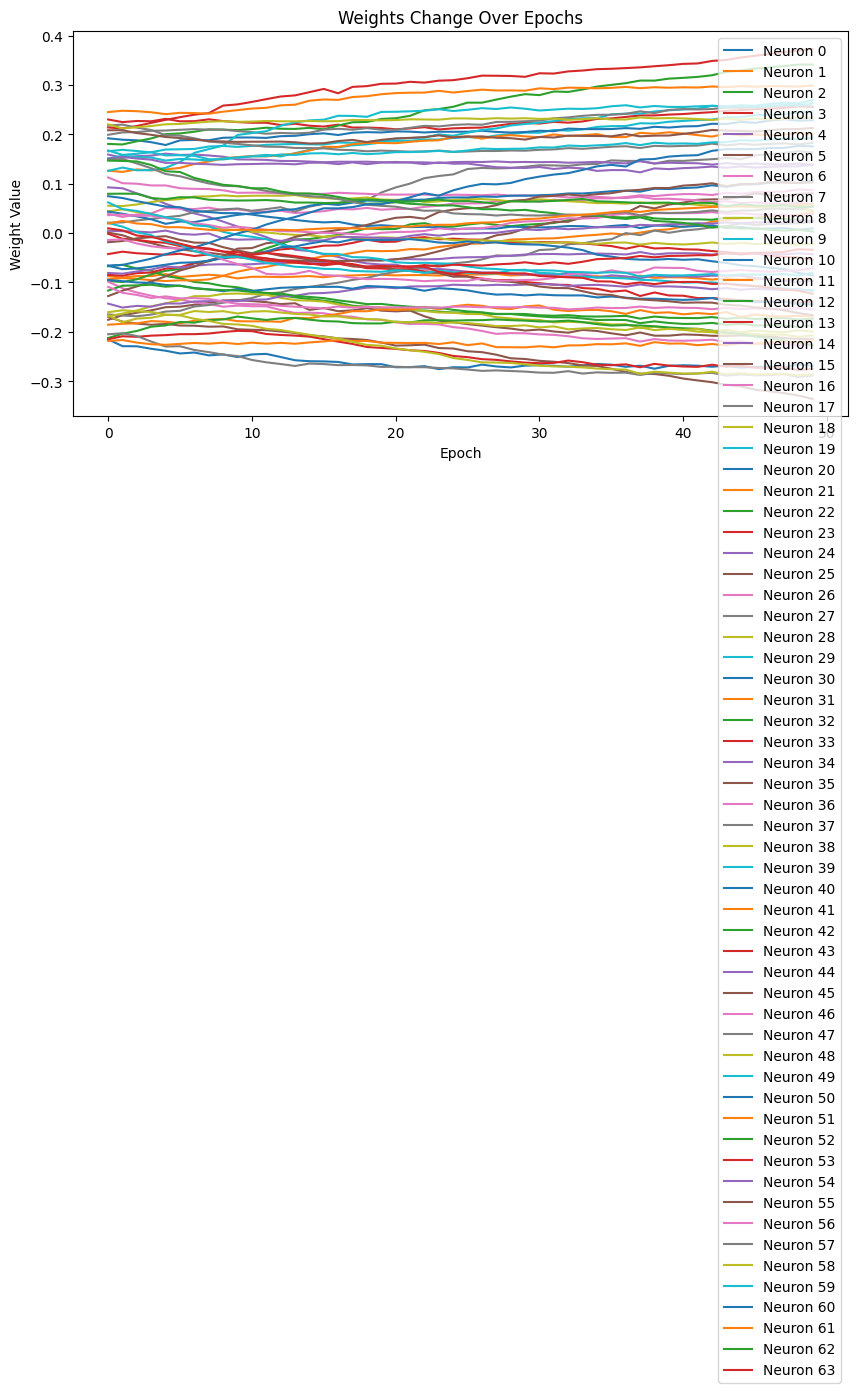

3/3 - 0s - loss: 0.6830 - accuracy: 0.8316 - 26ms/epoch - 9ms/step

Test accuracy: 0.8315789699554443
3/3 [==============================] - 0s 1ms/step
[[0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        43
           1       0.85      0.85      0.85        52

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class WeightsHistory(Callback):
    def on_train_begin(self, logs={}):
        self.weights = []

    def on_epoch_end(self, epoch, logs={}):
        self.weights.append(self.model.layers[0].get_weights()[0])

    def on_train_end(self, logs={}):
        weights = np.array(self.weights)
        plt.figure(figsize=(10, 5))
        for i in range(weights.shape[2]):
            plt.plot(weights[:, 0, i], label=f'Neuron {i}')
        plt.title('Weights Change Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Weight Value')
        plt.legend()
        plt.show()

# Load the dataset
loan_data = pd.read_excel('R:/NEU/SEM4-FALL/Generative-AI/data/loan.xlsx')

# Data Cleaning: Ensure all string data is consistently formatted
loan_data = loan_data.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

categorical_cols = ['Sex', 'Res_status', 'Telephone', 'Occupation', 'Job_status', 'Liab_ref', 'Acc_ref']
numerical_cols = ['Age', 'Time_at_address', 'Time_employed', 'Time_bank', 'Home_Expn', 'Balance']

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X = loan_data.drop('Decision', axis=1)
y = loan_data['Decision'].map({'accept': 1, 'reject': 0})  # Encode the target variable

X_prepared = preprocessor.fit_transform(X)

# Data Balancing: Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_prepared, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

weight_history = WeightsHistory()

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=10, 
    validation_data=(X_test, y_test), 
    callbacks=[weight_history],
    verbose=1
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)


### for question 3 i have already included the data processing steps in backpropogation classifier 

#### For more indepth understanding we use realistic data to see every 10 aspect of data preprocessing steps

### Expand each of those ten aspects of data preparation discussed in the class with a short 1-2 sentence description and an example. Submit the write up in a word document.

In [ ]:
# Data Collection: Gathering data from various sources.
# Data Integration: Merging data from disparate sources to create a new cohesive dataset.
# Data Cleaning: Removing inaccuracies and noise and correcting errors in the data.
# Data Transformation: Changing the format, structure, or values of data to suit for building the model.
# Data Reduction: Reducing the volume but producing the same or similar analytical results.
# Data Discretization: Transforming continuous data into discrete bins or intervals.
# Data Imputation: Filling in missing or null values in datasets.
# Data Encoding: Converting categorical data into numerical format.
# Data Balancing: Adjusting the dataset to address imbalances in the target variable.
# Feature Engineering: Selecting or creating new features from existing data to improve model performance.

In [7]:
import pandas as pd

# Load the dataset
file_path = "../data/Realistic_Loan_Dataset.csv"
loan_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(loan_df.head())

# Data types
print("\nData types of each column:")
print(loan_df.dtypes)

# Summary statistics for numerical attributes
print("\nSummary statistics for numerical attributes:")
print(loan_df.describe())

# Distribution of categorical variables
print("\nDistribution of categorical variables:")
for col in loan_df.select_dtypes(include='object').columns:
    print(f"\nDistribution for {col}:")
    print(loan_df[col].value_counts())

# Missing values count
print("\nMissing values count in each column:")
print(loan_df.isnull().sum())

# Unique values count
print("\nUnique values count in each column:")
print(loan_df.nunique())

# Correlations between numerical variables
print("\nCorrelation matrix:")
print(loan_df.corr())


First few rows of the dataset:
   Loan ID  Customer ID  Loan Amount  Interest Rate  Loan Duration  \
0        1        78268      28342.0          10.23              3   
1        2        53567      10974.0           9.24             20   
2        3        52613      35523.0            NaN              5   
3        4        55891      49356.0           9.29             10   
4        5        31243      10353.0           6.39             20   

   Annual Income  Credit Score Marital Status Employment Status  \
0       109072.0         370.0         Single     Self-employed   
1        61753.0         483.0        Married          Employed   
2       144006.0         404.0       Divorced        Unemployed   
3            NaN         598.0       Divorced        Unemployed   
4        86305.0         825.0         Single        Unemployed   

  Previous Default Loan Purpose Approval Status  
0              Yes         Home          Denied  
1               No         Home        Approv

C:\Users\patel\AppData\Local\Temp\ipykernel_16236\1874266175.py:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(loan_df.corr())


In [8]:
# data preprocessing 

In [9]:
import pandas as pd
import numpy as np

file_path = "../data/Realistic_Loan_Dataset.csv"
loan_df = pd.read_csv(file_path)

# Remove rows with 'Complicated' in Marital Status
loan_df = loan_df[loan_df['Marital Status'] != 'Complicated']

# Handle missing values by temporarily filling with median (will be properly imputed later)
loan_df.fillna(loan_df.median(), inplace=True)

# Data Transformation
# Convert 'Loan Duration' from years to months
loan_df['Loan Duration Months'] = loan_df['Loan Duration'] * 12

# Data Reduction
# Sample 10% of the data to reduce size
loan_df_sampled = loan_df.sample(frac=0.1, random_state=1)

# Data Discretization
# Bin 'Annual Income' into categories
loan_df['Income Category'] = pd.cut(loan_df['Annual Income'], bins=3, labels=["Low", "Medium", "High"])

# Data Imputation
# Impute missing 'Credit Score' with the median of the column
loan_df['Credit Score'].fillna(loan_df['Credit Score'].median(), inplace=True)

# Data Encoding
# Encode categorical variables using get_dummies
loan_df_encoded = pd.get_dummies(loan_df, columns=['Marital Status', 'Employment Status', 'Loan Purpose'])

# Data Balancing
# Balance the dataset by oversampling the minority class in 'Approval Status'
from sklearn.utils import resample
df_majority = loan_df[loan_df['Approval Status']=='Approved']
df_minority = loan_df[loan_df['Approval Status']=='Denied']
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)
loan_df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Feature Engineering
# Create a new feature 'Debt-to-Income Ratio'
loan_df['Debt-to-Income Ratio'] = loan_df['Loan Amount'] / loan_df['Annual Income']

# Save the processed dataset
loan_df.to_csv("../data/Processed_Loan_Dataset.csv", index=False)


C:\Users\patel\AppData\Local\Temp\ipykernel_16236\4137333691.py:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_df.fillna(loan_df.median(), inplace=True)


In [11]:
# Distribution of categorical variables
print("\nDistribution of categorical variables:")
for col in loan_df.select_dtypes(include='object').columns:
    print(f"\nDistribution for {col}:")
    print(loan_df[col].value_counts())

# Missing values count
print("\nMissing values count in each column:")
print(loan_df.isnull().sum())


Distribution of categorical variables:

Distribution for Marital Status:
Divorced    66253
Single      66025
Married     65722
Name: Marital Status, dtype: int64

Distribution for Employment Status:
Employed         66202
Unemployed       65957
Self-employed    65841
Name: Employment Status, dtype: int64

Distribution for Previous Default:
No     99364
Yes    98636
Name: Previous Default, dtype: int64

Distribution for Loan Purpose:
Education    49555
Personal     49535
Home         49474
Car          49436
Name: Loan Purpose, dtype: int64

Distribution for Approval Status:
Approved    99250
Denied      98750
Name: Approval Status, dtype: int64

Missing values count in each column:
Loan ID                 0
Customer ID             0
Loan Amount             0
Interest Rate           0
Loan Duration           0
Annual Income           0
Credit Score            0
Marital Status          0
Employment Status       0
Previous Default        0
Loan Purpose            0
Approval Status       

# lets conclusion of what this entire jupyter note book is doing for assignment


RAG Implementation:

Defining utility functions: Functions for retrieving information and generating responses (both with RAG and without) are defined. This shows a practical implementation of the RAG technique, leveraging retrieved documents to inform and enhance generative responses.
Comparing RAG with standard responses: By comparing outputs from both RAG-enhanced and standard generative models, the notebook illustrates the effectiveness of RAG in reducing hallucination and improving response relevance.
Application in a Practical Scenario:

Loan application classifier using back-propagation: <br>
A deep learning classifier is developed to predict loan approval outcomes. This section integrates numerous data preprocessing steps necessary for real-life applications, such as handling missing values, encoding categorical data, and balancing datasets.
Visualizing changes in model weights: The notebook includes an innovative approach to visualize how weights in a neural network change over time, providing insights into the learning process of the model.
Comprehensive Data Preparation Discussion:

Extensive data processing steps: <br>
 Each preprocessing step is explained and demonstrated, including data collection, cleaning, transformation, reduction, and more. This section is crucial for preparing the dataset for model training and provides a practical view of preparing real-world data for complex machine learning tasks.


